In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import h5py
from scipy.ndimage.filters import gaussian_filter

import py4DSTEM
from py4DSTEM.process.dpc import get_wavenumber

In [2]:
# Load data

fp = "/home/ben/Data/20190509_DPC_MoS2_binned_HamishBrown/MoS2_binned.h5"
f = h5py.File(fp,'r')
data = np.array(f['4D-STEM_data/datacube/datacube'])
f.close()

dc = py4DSTEM.file.datastructure.DataCube(data[:,:255,:,:])

In [3]:
dc.data4D.shape

(256, 255, 63, 64)

### Display data

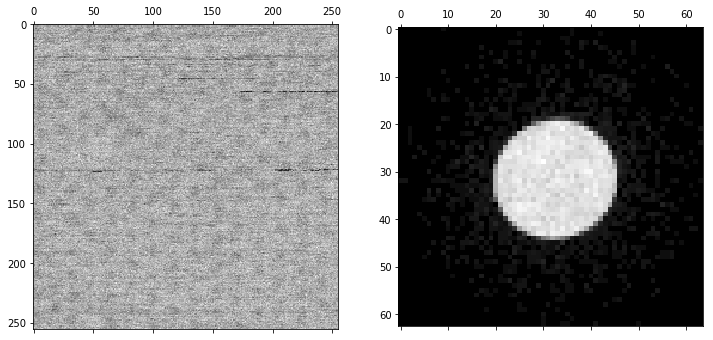

In [4]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data4D,axis=(2,3))
DP = dc.data4D[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### DPC

In [5]:
rsize = [40,40]
keV = 60
alpha = 30.6*1e-3
kalpha = get_wavenumber(keV*1e3)*alpha

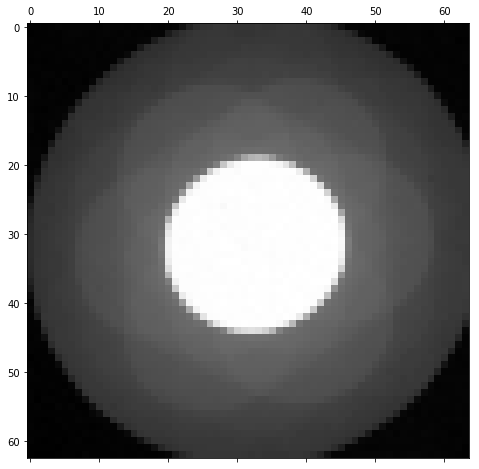

In [9]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data4D,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

### Hamish's GIU

The function call is:
    
```
origin, size, rotation, flip = Diffraction_sizing_and_rotation(PACBED,datacube)
```

We want to get all of these pieces!

#### 1. Get CBED center and radius

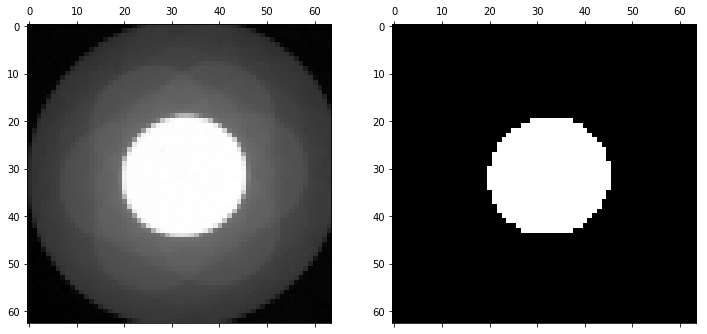

In [100]:
thresh = .5
power=0.1

mask = PACBED > np.max(PACBED)*thresh

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(PACBED**power)
ax2.matshow(mask)
plt.show()

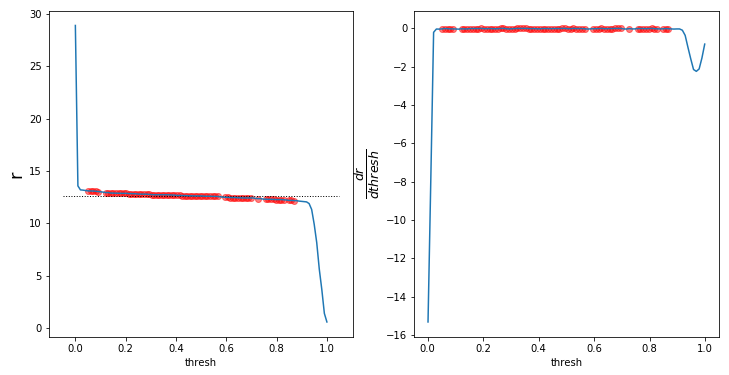

r = 12.624


In [107]:
# Get bright field disk radius

N = 100
thresh_lower = 0.001
thresh_upper = 0.999

thresh_vals = np.linspace(thresh_lower,thresh_upper,N)
r_vals = np.zeros(N)

for i in range(len(thresh_vals)):
    thresh = thresh_vals[i]
    mask = PACBED > np.max(PACBED)*thresh
    r_vals[i] = np.sqrt(np.sum(mask)/np.pi)

dr_dtheta = np.gradient(r_vals)
mask = (dr_dtheta <= 0) * (dr_dtheta >= 2*np.median(dr_dtheta)) 

r = np.average(r_vals[mask])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(thresh_vals,r_vals)
ax2.plot(thresh_vals,dr_dtheta)
ax1.scatter(thresh_vals[mask],r_vals[mask],color='r',alpha=0.5)
ax2.scatter(thresh_vals[mask],dr_dtheta[mask],color='r',alpha=0.5)
ax1.hlines(r,ax1.get_xlim()[0],ax1.get_xlim()[1],linestyle=':',linewidth=1)
ax1.set_xlabel('thresh')
ax1.set_ylabel('r',size=18)
ax2.set_xlabel('thresh')
ax2.set_ylabel(r'$\frac{dr}{dthresh}$',size=18)
plt.show()

print("r = {:.5}".format(r))

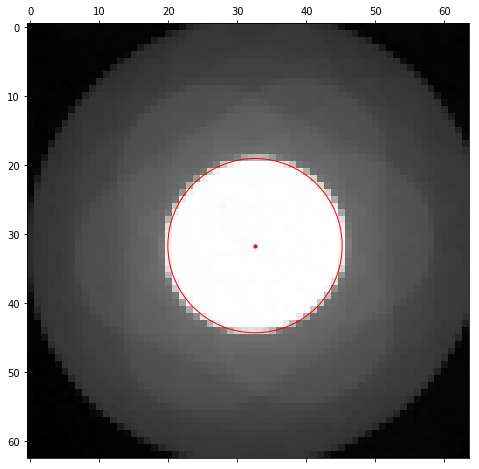

In [108]:
# Get the bright field disk center, and plot

sigma = 10
x0,y0 = py4DSTEM.process.utils.get_CoM(PACBED)

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

#### 2. Get rotation and flip